# **Tutorial 5: Scaling up with Pyspark** 

In this section of the tutorial, we demonstrate how to process a much larger mobility dataset using nomad's software in a Spark cluster. We begin with a fundamental demonstration of how Spark's optimized execution plan works.

## Configure the cluster

In [1]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder 
	.master("local[3]") 
	.appName("My local cluster")
	.config("spark.driver.memory", "3g")
    .config("spark.driver.maxResultSize", "7g")
	.config("spark.executor.memory", "4g")
    .config("spark.executor.cores", "3")
    .config("spark.jars.packages",
            "org.apache.hadoop:hadoop-aws:3.3.4,"
            "com.amazonaws:aws-java-sdk-bundle:1.12.633")
    .config("spark.hadoop.fs.s3a.aws.credentials.provider",
              "com.amazonaws.auth.DefaultAWSCredentialsProviderChain")
	.getOrCreate()
        )

In [ ]:
### Need to use a specific virtual environment with python 3.9
# # — ensure both driver and executors use the same Python binary —
# os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\Users\pacob\AppData\Local\Programs\Python\Python312\python.exe"
# os.environ["PYSPARK_PYTHON"]        = r"C:\Users\pacob\AppData\Local\Programs\Python\Python312\python.exe"

## A not-that-off-topic example: count intersecting time intervals

A large number of events := `(event_id, start_datetime, end_datetime)` need to be compared to find the pairs that intersect. 
- Events are all under 2 hours long
- Simple sorting can be a bottleneck

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
import datetime as dt

In [ ]:
N = 25_000_000
parts = 250
sec_in_3_weeks = 3 * 7 * 24 * 3600
a_totally_normal_day = int(dt.datetime(2021, 1, 6).timestamp())

events = (spark.range(N, numPartitions=parts)
          # seconds offset into a 7‑day window
          .withColumn("offset", (F.rand() * sec_in_3_weeks).cast("int"))
          # duration drawn from [60s, 7200s] 1min to 2 hours
          .withColumn("duration", (F.rand() * 7140 + 60).cast("int"))
          .withColumn("start", F.from_unixtime(a_totally_normal_day + F.col("offset")).cast("timestamp"))
          .withColumn("end",   F.from_unixtime(a_totally_normal_day + F.col("offset") + F.col("duration")).cast("timestamp"))
          .select("id", "start", "end")
         )

In [ ]:
events.show(5, truncate=False)
print(f"Initial partitions: {events.rdd.getNumPartitions()}")

print("Rows in first ten partitions:",
      events.rdd.mapPartitions(lambda it: [sum(1 for _ in it)]).take(10))

### Map the problem to buckets

In [ ]:
bucketed = (events.withColumn("bucket",
                F.explode(
                    F.array(
                        F.floor(F.unix_timestamp("start")/3600),
                        F.floor(F.unix_timestamp("end")  /3600)
                    )))
            .repartition("bucket")) # <<< SHUFFLE

# No execution yet!

In [ ]:
bucketed.show(5)

### Each chunk of data can be processed with a custom function

In [ ]:
from pyspark.sql import functions as F
import pandas as pd

def find_overlaps(pdf):
    ids = pdf["id"].values
    starts = pdf["start"].values
    ends = pdf["end"].values

    pairs = []
    n = len(ids)
    for i in range(n):
        for j in range(i + 1, n):
            if starts[i] <= ends[j] and starts[j] <= ends[i]:
                pairs.append((int(ids[i]), int(ids[j])))
    return pd.DataFrame(pairs, columns=["e1", "e2"])

overlaps = bucketed.groupby("bucket").applyInPandas(find_overlaps, "e1 int, e2 int").dropDuplicates(["e1","e2"])

In [ ]:
print(overlaps.explain())
print(overlaps.limit(1000).toPandas())

## Large Scale Mobility Data 

In [3]:
import nomad.io.base as loader
data_path = 's3://catalog-pickwell/tutorial-sample/'
loader.table_columns(data_path, format='parquet', sep = "\t")

Index(['timestamp', 'device_aid', 'device_aid_type', 'latitude', 'longitude',
       'horizontal_accuracy', 'altitude', 'altitude_accuracy',
       'location_method', 'ip', 'user_agent', 'OS', 'OS_version',
       'manufacturer', 'model', 'carrier', 'geography_id_1', 'date'],
      dtype='object')

In [4]:
traj_cols = {}

traj = spark.read.parquet('s3a://catalog-pickwell/tutorial-sample/', header=True, sep="\t")
traj.limit(5).toPandas()

,timestamp,device_aid,device_aid_type,latitude,longitude,horizontal_accuracy,altitude,altitude_accuracy,location_method,ip,user_agent,OS,OS_version,manufacturer,model,carrier,geography_id_1,date
0,1745290992,787280c5-048f-c804-a16d-3377374de6cd,AAID,34.09069300,-117.75457300,66.0,317.4,0,gps,None,None,Android,None,None,None,None,US,2025-04-22
1,1745291018,28c96bdb-92cf-4d9a-8f65-04320322d812,IDFA,34.22806000,-118.46859000,4.3,218,0,fused,None,None,iOS,13.3.1,Apple,None,None,US,2025-04-22
2,1745291030,28c96bdb-92cf-4d9a-8f65-04320322d812,IDFA,34.22803000,-118.46860000,14.7,218,0,fused,None,None,iOS,13.3.1,Apple,None,None,US,2025-04-22
3,1745290995,7730393f-010a-4863-a58d-cae4f2787dca,IDFA,33.95290000,-118.04338000,8.0,10.9,0,gps,None,None,iOS,None,Apple,None,None,US,2025-04-22
4,1745291015,8ce78bfb-2d62-4b3f-93c7-b63a5c96ff5d,IDFA,33.68109000,-117.92448000,12.0,-20.4,0,fused,None,None,iOS,None,Apple,None,None,US,2025-04-22


### Users in Center City Philadelphia

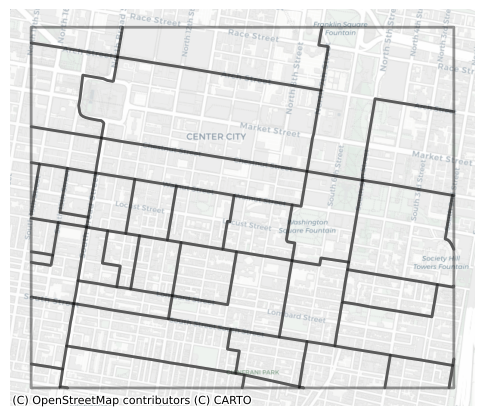

In [35]:
import geopandas as gpd
import shapely as shp
from shapely.geometry import box, LineString, Point
import contextily as cx

# center city Philadelphia
bbox = box(-75.1680, 39.9400, -75.1440, 39.9557)
old_city = gpd.GeoSeries([bbox], crs="EPSG:4326").to_crs("EPSG:3857").iloc[0]

cbgs = gpd.read_file("Census_Block_Groups_2010.geojson").to_crs("EPSG:3857")
ax = cbgs.clip(old_city).plot(figsize=(6, 6), alpha=0.4, facecolor="none", linewidth=2)
ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

In [ ]:
import geopandas as gpd

la_poly = "POLYGON ((-117.704725 34.093957, -117.730125 34.021371, -117.76769 34.023506, -117.767483 34.004611, -117.785062 34.004809,"\
          " -117.802539 33.975551, -117.783287 33.946411, -117.976498 33.94605, -117.976593 33.90281, -118.058918 33.846121, -118.063162"\
          " 33.81961, -118.084377 33.803433, -118.096705 33.779085, -118.09197 33.758472, -118.11951 33.737064, -118.1259 33.697151,"\
          " -118.237008 33.690595, -118.274239 33.663429, -118.319135 33.659547, -118.345415 33.663427, -118.466962 33.725524, -118.485577 33.753664,"\
          " -118.484483 33.803154, -118.443968 33.839057, -118.447254 33.84876, -118.557356 33.987673, -118.727459 33.980307, -118.809827 33.946905,"\
          " -118.841116 33.955371, -118.873998 33.983314, -118.951721 33.992858, -118.940965 34.07483, -118.788889 34.168214, -118.668152 34.168195,"\
          " -118.667713 34.240404, -118.632495 34.240426, -118.636789 34.291804, -118.894634 34.817972, -118.881729 34.817802, -118.883381 34.808637,"\
          " -118.870926 34.803109, -118.854114 34.803279, -118.854253 34.817772, -117.667292 34.822526, -117.667034 34.558008, -117.659994 34.55804,"\
          " -117.646374 34.28917, -117.704725 34.093957))"


poly = gpd.GeoSeries.from_wkt([la_poly])[0]
min_lon, min_lat, max_lon, max_lat = poly.bounds

filtered = (
    traj
    .filter(F.col("location_method").isin("gps", "fused")) # remove signals with location based on WIFI
    .filter(f"longitude BETWEEN {min_lon} AND {max_lon}")
    .filter(f"latitude  BETWEEN {min_lat} AND {max_lat}")
)

In [ ]:
approx_total_records = filtered.rdd.countApprox(timeout=10000, confidence=0.95) # in ms
print(f"Approximate total records: {approx_total_records}")

In [ ]:
approx_num_users = (
    filtered
    .agg(F.approx_count_distinct("device_aid", rsd=0.1).alias("approx_num_users"))
    .collect()[0]["approx_num_users"]
)
print(f"Approximate unique devices (device_aid): {approx_num_users}")

### Let's persist a small sample of users

In [ ]:
frac_users = 0.08

sample_df = (
    filtered
      .withColumn("_bucket", F.abs(F.xxhash64("device_aid")) % 1000)
      .filter(F.col("_bucket") < frac_users*1000)   # keep frac_users of the buckets
      .select("device_aid")
)

In [ ]:
pandas_df = sample_df.toPandas()
pandas_df.to_csv("sample_1pct_device_aid.csv", index=False)
print(pandas_df.head(10))

In [ ]:
# Better syntax?
data = filtered.join(
    sample_df.select("device_aid"),  # just need the key column
    on="device_aid",
    how="inner"
)

### Downsample to every 5 minutes and completeness

In [ ]:
def downsample(data, timestamp, user_id, periods=1, freq='min'):
    """
    Keep at most one row per `periods`×`freq` window per user.
    """
    if not isinstance(periods, int) or periods < 1:
        raise ValueError("periods must be a positive integer")
    # bucket size in seconds (freq='min' for now)
    window = periods * 60
    bucket_col = "_ts_bucket"
    return (
        data
        .withColumn(bucket_col, F.floor(F.col(timestamp) / window) * window)
        .orderBy(user_id, bucket_col, timestamp)
        .dropDuplicates([user_id, bucket_col])
        .drop(bucket_col)
    )

data_clean = downsample(data, "timestamp", "device_aid", periods=2).filter("horizontal_accuracy <= 50")
data_clean.show(10, truncate=False)

In [ ]:
# completeness
def completeness(data, timestamp, user_id, relative=False):
    """
    Per-user fraction of non-empty hour buckets.
    """
    # 1. bucket into hour‐start timestamps
    df = data.withColumn(
        "_hour",
        F.floor(F.col(timestamp) / 3600) * 3600
    )

    # 2. single aggregation: hit_hours, first_hour, last_hour
    stats = df.groupBy(user_id).agg(
        F.countDistinct("_hour").   alias("hit_hours"),
        F.min("_hour").             alias("first_hour"),
        F.max("_hour").             alias("last_hour"),
    )

    if relative:
        stats = stats.withColumn(
            "total_hours",
            (F.col("last_hour") - F.col("first_hour"))/3600 + F.lit(1)
        )
    else:
        glob = df.agg(
            F.min("_hour").alias("gmin"),
            F.max("_hour").alias("gmax")
        ).first()
        total = int((glob["gmax"] - glob["gmin"])/3600 + 1)
        stats = stats.withColumn(
            "total_hours",
            F.lit(total)
        )

    # 3. completeness ratio
    return stats.withColumn(
        "completeness",
        F.col("hit_hours") / F.col("total_hours")
    ).select(user_id, "completeness")


q_hourly = filters.completeness(traj, periods=1, freq='h', traj_cols=tc)

In [ ]:
import matplotlib.pyplot as plt

_q = q_hourly.toPandas()

fig, ax = plt.subplots(figsize=(10, 2))
ax.hist(_q, bins=20)
ax.set_title('Completeness (Hourly)')
ax.grid()

plt.show()

### Stop and persist stops

In [ ]:
import nomad.stop_detection.lachesis as LACHESIS

def lachesis_per_user(
    data_spark,
    dt_max,
    delta_roam,
    dur_min=5,
    complete_output=False,
    passthrough_cols=None,
    traj_cols=None,
    **kwargs
):
    """
    Run LACHESIS stop detection on every user in parallel (Spark).

    Parameters
    ----------
    data_spark : pyspark.sql.DataFrame
    dt_max, delta_roam, dur_min, complete_output, passthrough_cols, traj_cols
        Same meaning as in the original pandas implementation.
    **kwargs : forwarded to LACHESIS.lachesis

    Returns
    -------
    pyspark.sql.DataFrame  (stops)
    """
    passthrough_cols = passthrough_cols or []
    traj_cols = traj_cols or {}
    uid = traj_cols.get("user_id", "device_aid")

    def _lachesis(pdf):
        return LACHESIS.lachesis(
            pdf,
            dt_max          = dt_max,
            delta_roam      = delta_roam,
            dur_min         = dur_min,
            complete_output = complete_output,
            passthrough_cols= passthrough_cols + [uid],
            traj_cols       = traj_cols,
            **kwargs
        )

    schema = (
        f"{uid} string, "
        "start_ts long, end_ts long, "
        "lat double, lon double, "
        "duration_min double"
    )

    stops = (
        data_spark
        .groupBy(uid)
        .applyInPandas(_lachesis, schema)
    )

    return stops

In [ ]:
tc = {'longitude':'longitude',
             'latitude':'latitude',
             'ha':'horizontal_accuracy',
             'user_id':'device_aid',
             'timestamp':'timestamp',
             'date':'date'}

stops_df = lachesis_per_user(
    data_clean,
    dt_max=240,
    delta_roam=30,
    complete_output=True,
    passthrough_cols=["tz_offset"],
    traj_cols=tc)

# write to parquet, partitioned by user
(stops_df.write
         .mode("overwrite")
         .partitionBy("device_aid")
         .parquet("stops_data/"))

### Visualization

### Mobility metrics: % time at home, and radius of gyration

### Let's aggregate per Census Block Group and visualize

### Post-stratification